In [1]:
# General Imports
import numpy as np
import csv
from datetime import datetime as time
import os

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
# TeX Label Config
import matplotlib as mpl
mpl.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': 'cmr10',
    'mathtext.fontset': 'cm',
    'font.family': 'STIXGeneral',
    'font.size': 12,
    'axes.unicode_minus': True,
    'figure.autolayout': True,
    'legend.fontsize': 'large'
    })

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Sklearn
from sklearn.model_selection import train_test_split

# tqdm for progress bar
from tqdm import trange, tqdm

# ipython config
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [24]:
# Define Pauli matrices
s1 = np.array([[0,1],[1,0]])
s2 = np.array([[0,-1j],[1j,0]])
s3 = np.array([[1,0],[0,-1]])

pauli_matrices = np.array([s1, s2, s3])

In [25]:
def plot_dm(astate):

    # Init arrays
    dim = astate.shape[0]
    dz = astate.ravel()
    xpos, ypos = np.meshgrid(np.arange(dim), np.arange(dim))
    xpos = xpos.ravel()
    ypos = ypos.ravel()


    fig = plt.figure(dpi=80)

    # Init colorbar
    cmap = cm.get_cmap('plasma')
    norm = Normalize(vmin=min(dz), vmax=max(dz))
    colors = cmap(norm(dz))

    # 2D color plot
    ax = fig.add_subplot(5,7,(12,28))
    ax.imshow(astate, vmin=min(dz), vmax=max(dz), cmap=cmap)
    a=ax.set_xticks(xpos)
    a=ax.set_yticks(ypos)
    a=sc = cm.ScalarMappable(cmap=cmap,norm=norm)
    a=sc.set_array([])
    a=plt.colorbar(sc)


    # Classical 3D density matrix plot
    ax = fig.add_subplot(5,7,(1,32), projection='3d')
    a=ax.bar3d(x=xpos-.25, y=ypos-.25, z=0, dx=0.5, dy=0.5, dz=dz, color=colors)
    a=ax.set_xticks(xpos)
    a=ax.set_yticks(ypos)
    a=ax.set_zticks([])
    a=ax.set_zlim(-max(dz), max(dz))
    a=ax.grid(False)
    #Plot grid on z=0
    for i in range(dim):
        a=ax.plot(i*np.ones(dim), np.arange(dim), 0, color='k', lw=.5)
        a=ax.plot(np.arange(dim), i*np.ones(dim), 0, color='k', lw=.5)

    plt.show()

## Generate single qubit states from Bloch vectors

Pure state


array([ 0.09466986, -0.72887882, -0.67806584])

1.0

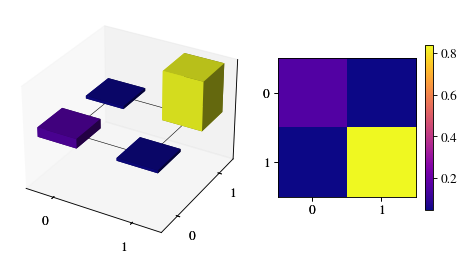

Mixed state


array([-0.00113476, -0.0032305 , -0.0135856 ])

0.014010438173522098

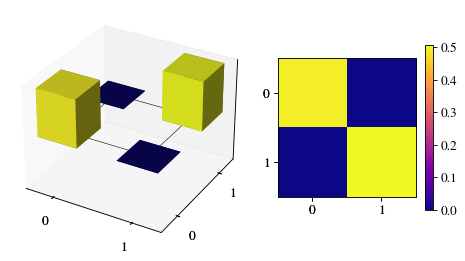

In [26]:
def random_bloch(pure):
    if pure:
        r = 1
    else:
        r = np.random.uniform(low=0, high=1)
    phi, theta = np.random.uniform(low=0, high=1, size=2)
    phi *= 2*np.pi
    theta *= np.pi
    return r * np.array([   np.cos(phi)*np.sin(theta),
                            np.sin(phi)*np.sin(theta),
                            np.cos(theta)
                        ])

def bloch2mat(vec):
    assert vec.shape[0] == 3
    r_sig = vec[0] * s1 + vec[1] * s2 + vec[2] * s3
    return np.array((np.eye(2) + r_sig) /2)



# Testing
print("Pure state")
test_1q = random_bloch(pure=True)
test_1q
np.linalg.norm(test_1q)
plot_dm(np.real(bloch2mat(test_1q)))

print("Mixed state")
test_1q = random_bloch(pure=False)
test_1q
np.linalg.norm(test_1q)
plot_dm(np.real(bloch2mat(test_1q)))

# 1-Qubit Measurement

Habe ich mit bloch vektoren alle möglichen observablen abgedeckt?

State Tomography: How many measurements are needed to correctly identify the state? 3^n for pure

For 1-Qubit: 3 Measurements are needed
--> Bloch vector

Simple Approach: make much more measurements: 100

1. generate Random vectors m to measure along
2. measure along each m very often

### Measurement playground

In [28]:
# Create random measurements
def create_random_obs(pure, n=100):
    #n = number of distinct measurements
    return np.array([bloch2mat(random_bloch(pure)) for _ in range(n)])

def perform_measurements(rho, observables):
    return np.real( np.trace(observables.dot(rho), axis1=1, axis2=2) )

array([[ 0.45264314+0.j        , -0.06450989+0.00075321j],
       [-0.06450989-0.00075321j,  0.54735686+0.j        ]])

0.500342707841857

0.026993476214990587

Text(0.5, 1.0, 'Measuring same state with MIXED observables')

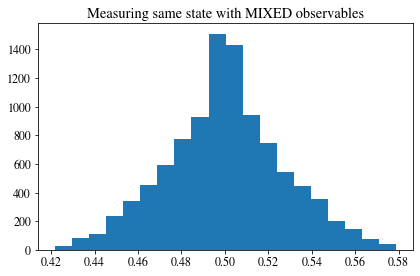

In [23]:
base_state = bloch2mat(random_bloch(pure=False))
base_state
observables = create_random_obs(pure=False, n=10000)

meas = perform_measurements(base_state, observables)
meas.mean()
meas.std()

a=plt.hist(meas, bins=20)
plt.title('Measuring same state with MIXED observables')
#a=plt.xlim(0,1)

array([[ 0.41519747+0.j        , -0.12629616+0.09322561j],
       [-0.12629616-0.09322561j,  0.58480253+0.j        ]])

0.4998540913503199

0.09936941505437079

Text(0.5, 1.0, 'Measuring same state with PURE observables')

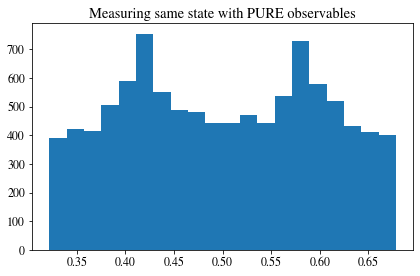

In [24]:
base_state = bloch2mat(random_bloch(pure=False))
base_state
observables = create_random_obs(n=10000, pure=True)

meas = perform_measurements(base_state, observables)
meas.mean()
meas.std()

a=plt.hist(meas, bins=20)
plt.title('Measuring same state with PURE observables')

### Read dataset

In [2]:
datadir = './data/states10000_obs100_2022-04-20_09:14:59/'
nstat = 10000
nobs = 100

y = np.zeros((0,3))
X = np.zeros((0,nobs))
data_obs = np.zeros((0,2,2))

# Read states
with open(datadir+'states.csv', 'r') as f:
  reader = csv.reader(f)
  for line in tqdm(reader):
    y = np.vstack((y, np.array(np.array(line).astype('float'))))

# Read observables
with open(datadir+'observables.csv', 'r') as f:
  reader = csv.reader(f)
  for line in tqdm(reader):
    data_obs = np.vstack((data_obs, np.array([np.array(line).reshape(2,2).astype('complex128')])))

# Read states
with open(datadir+'measurements.csv', 'r') as f:
  reader = csv.reader(f)
  for line in tqdm(reader):
    X = np.vstack((X, np.array(np.array(line).astype('float'))))


X_train, X_left, y_train, y_left = train_test_split(
    X, y, test_size=0.3, random_state=42)

X_valid, X_treasure, y_valid, y_treasure = train_test_split(
    X_left, y_left, test_size=0.4, random_state=42)

X.shape
y.shape
X_train.shape[0]
X_valid.shape[0]
X_treasure.shape[0]

10000it [00:00, 70600.01it/s]
100it [00:00, 26275.16it/s]
10000it [00:04, 2439.22it/s]


(10000, 100)

(10000, 3)

7000

1800

1200

In [3]:
class CustomDataset(Dataset):

  def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()

  def __len__(self):
        return len(self.X)

  def __getitem__(self, index):
        # Select sample
        X = self.X[index]

        # Load data and get label
        x = self.X[index]
        y = self.Y[index]

        return x, y

In [4]:
tomography_train_dataset = CustomDataset(X_train, y_train)
tomography_valid_dataset = CustomDataset(X_valid, y_valid)

In [5]:
# Define the batch size
BATCH_SIZE = 64

# Create data loaders from the datasets for the current task
# Setting drop_last=True does not consider the last batch in which there are less than BATCH_SIZE examples
tomography_train_dataloader = DataLoader(tomography_train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
tomography_valid_dataloader = DataLoader(tomography_valid_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

## Autoencoder architecture

In [113]:
class AutoencoderNet(nn.Module):

  def __init__(self, latent_size):
    super().__init__()

    self.latent_size = latent_size

    self.encoder = nn.Sequential(
    nn.Linear(100, 64),
    nn.ReLU(),
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,self.latent_size),
    )

    self.decoder = nn.Sequential(
    nn.Linear(self.latent_size, 32),
    nn.ReLU(),
    nn.Linear(32,64),
    nn.ReLU(),
    nn.Linear(64,100),
    )

  def forward(self, x):
    minrep = self.encoder(x)
    output = self.decoder(minrep)
    return output, minrep

In [87]:
# Function for training the network
def ae_train(net, train_epochs, train_dataloader, valid_dataloader, optimizer, criterion):

    train_losses = np.array([])
    valid_losses = np.array([])

    for epoch in trange(train_epochs):
        net.train()
        for batch_idx, samples in enumerate(train_dataloader):
            data, target = samples[0].to(device), samples[1].to(device)
            # Optimize parameters
            net.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            train_losses = np.append(train_losses, loss.clone().detach().cpu().numpy())

            # Check loss on validation set
            valid_batch_loss = np.array([])
            for valid_batch in valid_dataloader:
                valid_measurements = valid_batch[0].to(device)
                valid_outputs = net(valid_measurements)
                valid_loss = criterion(valid_outputs, valid_measurements).clone().detach().cpu().numpy()
                valid_batch_loss = np.append(valid_batch_loss, valid_loss)
            valid_losses = np.append(valid_losses, np.mean(valid_batch_loss))

    return train_losses, valid_losses

### Latent_size = 5

In [88]:
# Check if the GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Create the network on the CPU/GPU
net5 = AutoencoderNet(latent_size=5).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(net5.parameters(), lr=0.5)

train_losses, valid_losses = ae_train(net5, 1, tomography_train_dataloader, tomography_valid_dataloader, optimizer, criterion)

cpu


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


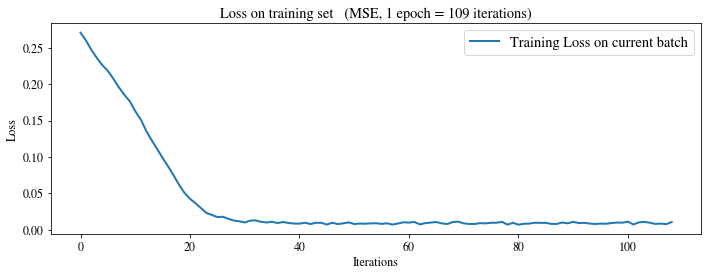

/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


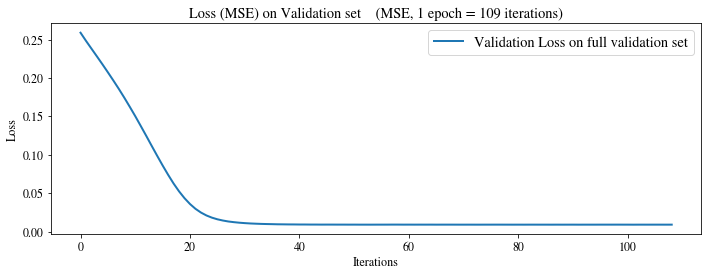

In [89]:
def plot_train_stats(train_losses, valid_losses, batchsize):
    it_per_epoch = X_train.shape[0] // batchsize

    a=plt.figure(figsize=(10,4))
    a=plt.plot(train_losses, lw=2, label='Training Loss on current batch')
    a=plt.xlabel('Iterations')
    a=plt.ylabel('Loss')
    a=plt.legend()
    a=plt.title(f'Loss on training set \t (MSE, 1 epoch = {it_per_epoch} iterations)')
    plt.show()

    a=plt.figure(figsize=(10,4))
    a=plt.plot(valid_losses, lw=2, label='Validation Loss on full validation set')
    a=plt.xlabel('Iterations')
    a=plt.ylabel('Loss')
    a=plt.legend()
    a=plt.title(f'Loss (MSE) on Validation set  \t (MSE, 1 epoch = {it_per_epoch} iterations)')
    plt.show()

In [90]:
train_losses[-1]
valid_losses[-1]

0.01074278075248003

0.00924161306050207

### Latent_size = 3

In [91]:
# Check if the GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Create the network on the CPU/GPU
net3 = AutoencoderNet(latent_size=3).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(net3.parameters(), lr=0.5)

train_losses, valid_losses = train(net3, 1, tomography_train_dataloader, tomography_valid_dataloader, optimizer, criterion)

cpu


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


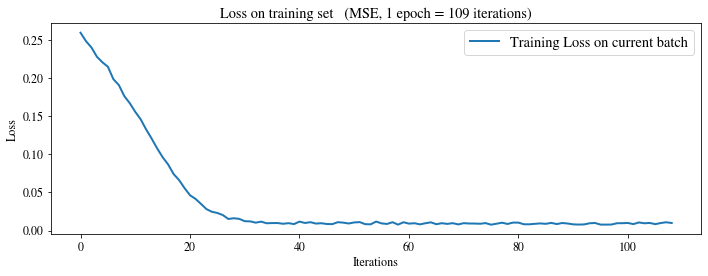

/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


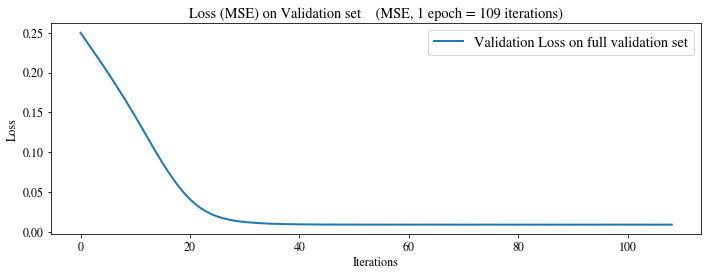

In [92]:
it_per_epoch = X_train.shape[0] // 64

a=plt.figure(figsize=(10,4))
a=plt.plot(train_losses, lw=2, label='Training Loss on current batch')
a=plt.xlabel('Iterations')
a=plt.ylabel('Loss')
a=plt.legend()
a=plt.title(f'Loss on training set \t (MSE, 1 epoch = {it_per_epoch} iterations)')
plt.show()

a=plt.figure(figsize=(10,4))
a=plt.plot(valid_losses, lw=2, label='Validation Loss on full validation set')
a=plt.xlabel('Iterations')
a=plt.ylabel('Loss')
a=plt.legend()
a=plt.title(f'Loss (MSE) on Validation set  \t (MSE, 1 epoch = {it_per_epoch} iterations)')
plt.show()

In [93]:
train_losses[-1]
valid_losses[-1]

0.009822268970310688

0.009253415062890522

### Latent_size = 1

In [94]:
# Check if the GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Create the network on the CPU/GPU
net1 = AutoencoderNet(latent_size=1).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(net1.parameters(), lr=0.5)

train_losses, valid_losses = train(net1, 1, tomography_train_dataloader, tomography_valid_dataloader, optimizer, criterion)

cpu


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


In [95]:
print(net1)

AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


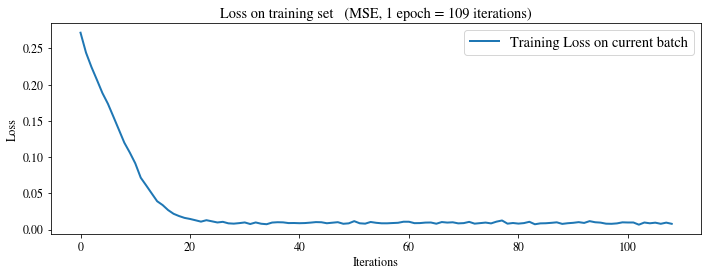

/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


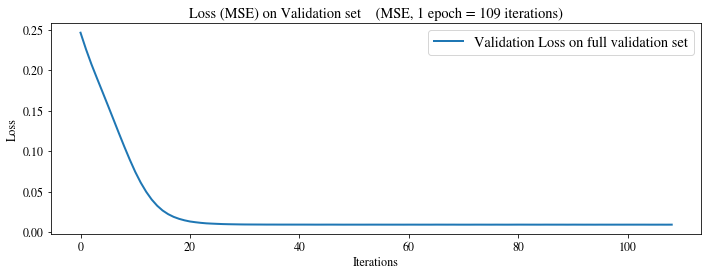

In [96]:
it_per_epoch = X_train.shape[0] // 64

a=plt.figure(figsize=(10,4))
a=plt.plot(train_losses, lw=2, label='Training Loss on current batch')
a=plt.xlabel('Iterations')
a=plt.ylabel('Loss')
a=plt.legend()
a=plt.title(f'Loss on training set \t (MSE, 1 epoch = {it_per_epoch} iterations)')
plt.show()

a=plt.figure(figsize=(10,4))
a=plt.plot(valid_losses, lw=2, label='Validation Loss on full validation set')
a=plt.xlabel('Iterations')
a=plt.ylabel('Loss')
a=plt.legend()
a=plt.title(f'Loss (MSE) on Validation set  \t (MSE, 1 epoch = {it_per_epoch} iterations)')
plt.show()

In [97]:
train_losses[-1]
valid_losses[-1]

0.007871833629906178

0.009225402642706675

Latent 0 test

In [115]:
# Check if the GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Create the network on the CPU/GPU
net0 = AutoencoderNet(latent_size=0).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(net0.parameters(), lr=0.5)

#train_losses, valid_losses = train(net0, 1, tomography_train_dataloader, tomography_valid_dataloader, optimizer, criterion)

cpu


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [112]:
print(net0)

AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=0, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=0, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


In [117]:
bloch_orig = random_bloch(pure=False)
measurement_orig = torch.Tensor(perform_measurements(bloch2mat(bloch_orig), data_obs))
pred0, minrep0 = net0.forward(measurement_orig.to(device))

minrep0

tensor([], grad_fn=<AddBackward0>)

/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


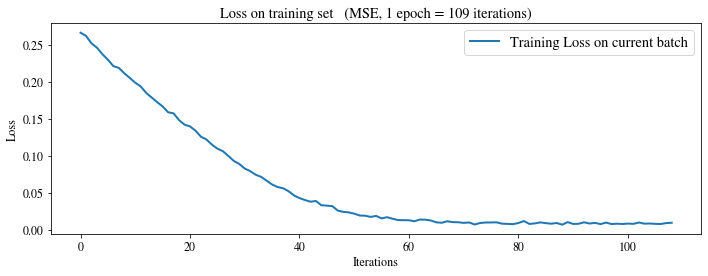

/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


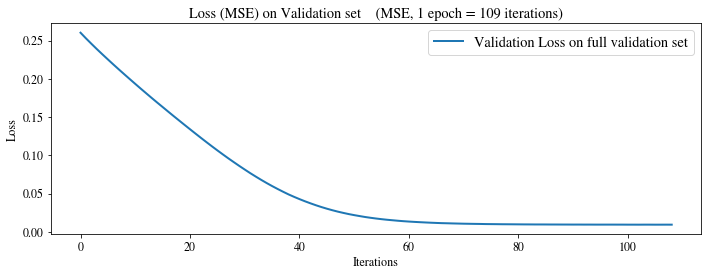

In [111]:
it_per_epoch = X_train.shape[0] // 64

a=plt.figure(figsize=(10,4))
a=plt.plot(train_losses, lw=2, label='Training Loss on current batch')
a=plt.xlabel('Iterations')
a=plt.ylabel('Loss')
a=plt.legend()
a=plt.title(f'Loss on training set \t (MSE, 1 epoch = {it_per_epoch} iterations)')
plt.show()

a=plt.figure(figsize=(10,4))
a=plt.plot(valid_losses, lw=2, label='Validation Loss on full validation set')
a=plt.xlabel('Iterations')
a=plt.ylabel('Loss')
a=plt.legend()
a=plt.title(f'Loss (MSE) on Validation set  \t (MSE, 1 epoch = {it_per_epoch} iterations)')
plt.show()

## Performance on unseen data

# Inference

In [ ]:
untrained_net = AutoencoderNet(latent_size=1)

In [109]:
bloch_orig = random_bloch(pure=False)
measurement_orig = torch.Tensor(perform_measurements(bloch2mat(bloch_orig), data_obs))
pred5 = net5.forward(measurement_orig.to(device))
pred3 = net3.forward(measurement_orig.to(device))
pred1 = net1.forward(measurement_orig.to(device))
baseline_pred = untrained_net.forward(measurement_orig.to(device))

print('net5', criterion(pred5, measurement_orig))
print('net3', criterion(pred3, measurement_orig))
print('net1', criterion(pred1, measurement_orig))
print('untrained net', criterion(baseline_pred, measurement_orig))

net5 tensor(0.0288, grad_fn=<MseLossBackward0>)
net3 tensor(0.0300, grad_fn=<MseLossBackward0>)
net1 tensor(0.0290, grad_fn=<MseLossBackward0>)
untrained net tensor(0.3174, grad_fn=<MseLossBackward0>)


In [69]:
# Comparison with untrained network


bloch_orig = random_bloch(pure=False)
measurement_orig = torch.Tensor(perform_measurements(bloch2mat(bloch_orig), data_obs))
measurement_pred = untrained_net.forward(measurement_orig.to(device))

criterion(measurement_pred, measurement_orig)

tensor(0.2758, grad_fn=<MseLossBackward0>)